https://www.kaggle.com/pranavraikokte/covid19-image-dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4097)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [2]:
# Step 1: Loading in Dataset
ds_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/train'
os.listdir(ds_directory)
ts_directory = '/home/zrarnz/9-Projects/ECET380/IntelImageSceneClassification/test'

base_class = tf.keras.applications.xception
base_net = base_class.Xception


In [3]:
curr_base_name = base_class.__name__.rsplit('.',1)[1]

In [4]:
# Load in ordered dataset
BATCH_SIZE = 8
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
train_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="training",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [5]:
val_set = image_dataset_from_directory(ds_directory,
                        shuffle=True,
                        validation_split=0.2,
                        subset="validation",
                        seed=123,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [6]:
test_set = image_dataset_from_directory(ts_directory,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        image_size=IMG_SIZE,
                        labels="inferred",
                        label_mode='int')

Found 3000 files belonging to 6 classes.


In [7]:
train_set.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [8]:
tf.keras.applications.xception# dataset_size = 181
# batch_size = BATCH_SIZE

def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = base_class.preprocess_input(image)
    return final_image, label

# train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).prefetch(1)
val_set = val_set.map(preprocess).prefetch(1)
test_set = test_set.map(preprocess).prefetch(1)

In [9]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 1404
Number of validation batches: 351
Number of test batches: 375


In [10]:
base_model = base_net(input_shape=IMG_SHAPE,
                                                  input_tensor=None,
                                               include_top=False,
                                               pooling=None,
                                                classes=1000,
                                               weights='imagenet')

In [11]:
for layer in base_model.layers:
    layer.trainable = False

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(
    units = 6, 
    activation = "softmax")(avg)

model = keras.models.Model(
    inputs = base_model.input,
    outputs = output)

model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate = 0.02,
        ),
    loss = "sparse_categorical_crossentropy", 
    metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [12]:
# tuner = kt.RandomSearch(
#             model_builder,
#             objective='val_accuracy',
#             max_trials=27,
#             seed=0,
#             overwrite=True,
#             executions_per_trial=2)

In [13]:
pre_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
pre_chckp = keras.callbacks.ModelCheckpoint(curr_base_name + "_intelscene_pretune.h5", save_best_only=True)

In [14]:
len(model.trainable_variables)


2

In [15]:
model.fit(train_set,
            validation_data=val_set,
            epochs=32,
            callbacks=[pre_early, pre_chckp],
#             steps_per_epoch=int(0.75 * DATASET_SIZE / BATCH_SIZE),
#             validation_steps=int(0.15 * DATASET_SIZE / BATCH_SIZE),
            )

Epoch 1/32
1404/1404 [==============================] - 104s 72ms/step - loss: 0.4932 - accuracy: 0.8371 - val_loss: 0.2563 - val_accuracy: 0.9070
Epoch 2/32
1404/1404 [==============================] - 122s 87ms/step - loss: 0.2636 - accuracy: 0.9013 - val_loss: 0.2404 - val_accuracy: 0.9091
Epoch 3/32
1404/1404 [==============================] - 190s 135ms/step - loss: 0.2405 - accuracy: 0.9105 - val_loss: 0.2461 - val_accuracy: 0.9045
Epoch 4/32
1404/1404 [==============================] - 192s 136ms/step - loss: 0.2286 - accuracy: 0.9178 - val_loss: 0.2318 - val_accuracy: 0.9116
Epoch 5/32
1404/1404 [==============================] - 198s 141ms/step - loss: 0.2204 - accuracy: 0.9203 - val_loss: 0.2351 - val_accuracy: 0.9081
Epoch 6/32
1404/1404 [==============================] - 202s 144ms/step - loss: 0.2108 - accuracy: 0.9226 - val_loss: 0.2226 - val_accuracy: 0.9159
Epoch 7/32
1404/1404 [==============================] - 204s 145ms/step - loss: 0.2029 - accuracy: 0.9251 - val_lo

In [16]:
model.evaluate(test_set)

375/375 [==============================] - 49s 130ms/step - loss: 0.2222 - accuracy: 0.9143


[0.22215209901332855, 0.9143333435058594]

In [17]:

train_set = train_set.shuffle(1000)


In [18]:
print('Number of fullset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of fullset batches: 1404
Number of validation batches: 351
Number of test batches: 375


In [19]:
model2 = tf.keras.models.load_model(curr_base_name + "_intelscene_pretune.h5")

In [20]:
for layer in model2.layers:
        layer.trainable=True

In [21]:
optimizer2 = keras.optimizers.SGD(learning_rate=0.002)

In [22]:
post_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
post_chckp = keras.callbacks.ModelCheckpoint(curr_base_name + "_intelscene_posttune.h5", save_best_only=True)

In [23]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer2,
    metrics="accuracy"
)

In [24]:
history = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=64,
    callbacks=[post_early, post_chckp]
)

Epoch 1/64
1404/1404 [==============================] - 791s 550ms/step - loss: 0.5378 - accuracy: 0.8092 - val_loss: 0.2333 - val_accuracy: 0.9237
Epoch 2/64
1404/1404 [==============================] - 777s 545ms/step - loss: 0.3100 - accuracy: 0.8935 - val_loss: 0.2178 - val_accuracy: 0.9255
Epoch 3/64
1404/1404 [==============================] - 783s 550ms/step - loss: 0.2469 - accuracy: 0.9132 - val_loss: 0.2060 - val_accuracy: 0.9337
Epoch 4/64
1404/1404 [==============================] - 778s 546ms/step - loss: 0.2083 - accuracy: 0.9263 - val_loss: 0.2124 - val_accuracy: 0.9277
Epoch 5/64
1404/1404 [==============================] - 773s 542ms/step - loss: 0.1788 - accuracy: 0.9414 - val_loss: 0.1993 - val_accuracy: 0.9326
Epoch 6/64
1404/1404 [==============================] - 783s 550ms/step - loss: 0.1529 - accuracy: 0.9510 - val_loss: 0.2043 - val_accuracy: 0.9298
Epoch 7/64
1404/1404 [==============================] - 778s 547ms/step - loss: 0.1418 - accuracy: 0.9551 - val_

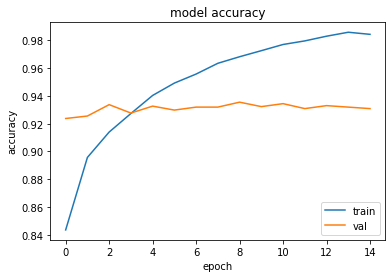

In [25]:
fig_acc = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [26]:
model2.evaluate(test_set)

375/375 [==============================] - 49s 131ms/step - loss: 0.2224 - accuracy: 0.9257


[0.22239606082439423, 0.9256666898727417]

In [27]:
evalPipe=test_set
for feats,lab in evalPipe.unbatch().batch(6000).take(1):
	probPreds=model2.predict(feats)

top1err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=1))
top5err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=5))
top10err=tf.reduce_mean(keras.metrics.sparse_top_k_categorical_accuracy(lab,probPreds,k=10))
print(top10err, top5err, top1err)

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9256667, shape=(), dtype=float32)
